In [1]:
import os
from glob import glob
from tqdm.auto import tqdm
import numpy as np

def read_txt(filepath):
  x = []
  y = []
  with open(filepath, 'r') as f:
    lines = f.readlines()
    for i, line in enumerate(lines[1:]):
      values = [float(val) for val in line.split('\t')]
      if len(values) != 10:
        continue
      x.append(values[:-1])
      y.append(int(values[-1]))
  assert len(x) == len(y)
  return x, y


def read_files():
  ROOT_FOLDER = os.path.join(os.getenv('HOME'), 'datasets', 'EMG', 'EMG_data_for_gestures-master')
  filepaths = glob(ROOT_FOLDER + '/**/*.txt')
  print('number of files: ', len(filepaths))

  X = []
  Y = []
  for filepath in tqdm(filepaths):
    x, y = read_txt(filepath)
    X += x
    Y += y
  return np.array(X).astype(np.float32), np.array(Y)


X, Y = read_files()
print('train X: ', X.shape)
print('train Y: ', Y.shape)

number of files:  72


  0%|          | 0/72 [00:00<?, ?it/s]

train X:  (4237907, 9)
train Y:  (4237907,)


number of data points for class 0: (2725157, 8)
number of data points for class 1: (250055, 8)
number of data points for class 2: (243193, 8)
number of data points for class 3: (249494, 8)
number of data points for class 4: (251570, 8)
number of data points for class 5: (251733, 8)
number of data points for class 6: (253009, 8)
number of data points for class 7: (13696, 8)


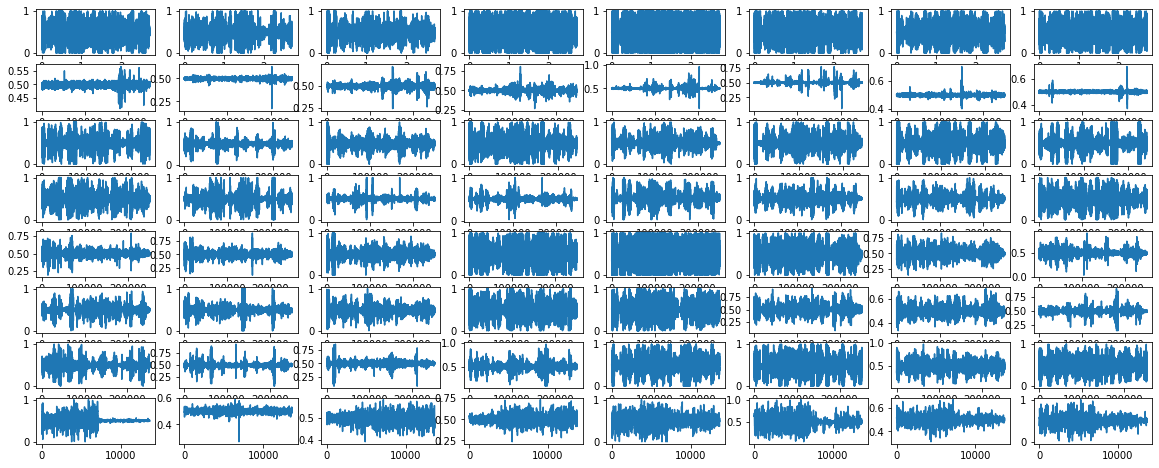

In [2]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


sc = MinMaxScaler(feature_range=(0, 1))
X = sc.fit_transform(X[:, 1:])

def visualize_data(X, Y, num_classes):
  fig, axes = plt.subplots(num_classes, 8, figsize=(20, 8))
  for c in range(num_classes):
    index = Y == c
    x = X[index]

    print(f'number of data points for class {c}: {x.shape}')
    for i in range(8):
      axes[c][i].plot(x[:, i])


n_classes = 8
visualize_data(X, Y, n_classes)
plt.show()

In [3]:
import tensorflow as tf

tf.version.VERSION

'2.11.0'

In [4]:
print(X[0], Y[0])
print(X[1], Y[1])

[0.49803925 0.49411768 0.49803925 0.49803925 0.49411768 0.5019608
 0.5019608  0.49803925] 0
[0.49803925 0.49411768 0.49803925 0.49803925 0.49411768 0.5019608
 0.5019608  0.49803925] 0


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.data import Dataset


sequence_len = 8
n_features = 8

classes = [0, 1,2,3,4,5,6,7]

# classes = [1,2,3,4,5,6,7]
# classes = [1,2,3,4]
# classes = [1,2]
# num_classes = 8
num_classes = len(classes)

def create_dataset(x, y):
  new_x = []
  new_y = []
  for i, c in enumerate(classes):
    index = y == c
    xi = x[index]
    num_points = len(xi)
    num_points = int(num_points // sequence_len * sequence_len)
    xi = xi[:num_points]
    xi = xi.reshape([-1, sequence_len, n_features])
    new_x.append(xi)
    new_y.append(np.full([len(xi), 1], i))
    print(f'datapoints for {c}: {num_points}')

  new_x = np.concatenate(new_x)
  new_y = np.concatenate(new_y)
  new_x, new_y = shuffle(new_x, new_y)
  return Dataset.from_tensor_slices((new_x, new_y))


train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.2)
print(f'Train x: {train_x.shape}, y: {train_y.shape}')
print(f'Test x: {test_x.shape}, y: {test_y.shape}')



train_dataset = create_dataset(train_x, train_y)
test_dataset = create_dataset(test_x, test_y)

batch_size = 1024
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)
print(train_dataset, test_dataset)

Train x: (3390325, 8), y: (3390325,)
Test x: (847582, 8), y: (847582,)
datapoints for 0: 2179800
datapoints for 1: 200152
datapoints for 2: 194912
datapoints for 3: 199592
datapoints for 4: 200920
datapoints for 5: 201408
datapoints for 6: 202512
datapoints for 7: 10992
datapoints for 0: 545352
datapoints for 1: 49896
datapoints for 2: 48272
datapoints for 3: 49888
datapoints for 4: 50640
datapoints for 5: 50320
datapoints for 6: 50488
datapoints for 7: 2696
<BatchDataset element_spec=(TensorSpec(shape=(None, 8, 8), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))> <BatchDataset element_spec=(TensorSpec(shape=(None, 8, 8), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))>


2023-03-13 03:32:56.920431: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


In [6]:
import tensorflow.keras as keras
import tensorflow.keras.layers as L
from tensorflow_addons.optimizers import AdamW
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

keras.backend.clear_session()

n_hidden = 64
num_heads = n_hidden
key_dim = 8
dropout = 0.1

def create_model():
  # inputs = keras.Input(shape=[sequence_len, n_features])
  # x = inputs
  # x = L.MultiHeadAttention(
  #   num_heads,
  #   key_dim,
  #   dropout=dropout)(x, x)
  # x = L.Reshape([64])(x)
  # x = L.Dense(n_hidden)(x)
  # x = L.ReLU()(x)
  # x = L.Dropout(dropout)(x)
  # x = L.Dense(num_classes)(x)
  # model = keras.models.Model(inputs=[inputs], outputs=[x])
  model = keras.models.Sequential([
    L.LSTM(n_hidden, input_shape=[sequence_len, n_features]),
    L.Dense(n_hidden),
    L.ReLU(),
    L.Dropout(dropout),
    L.Dense(num_classes),
  ])
  return model

model = create_model()
model.compile(
  # optimizer=AdamW(weight_decay=0.01, learning_rate=1e-3, epsilon=1e-8),
  optimizer=Adam(learning_rate=2e-4),
  loss=SparseCategoricalCrossentropy(from_logits=True),
  metrics=[SparseCategoricalAccuracy()]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                18688     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 re_lu (ReLU)                (None, 64)                0         
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 520       
                                                                 
Total params: 23,368
Trainable params: 23,368
Non-trainable params: 0
_________________________________________________________________


In [8]:
num_epochs = 1000

model.fit(
  train_dataset,
  validation_data=test_dataset,
  epochs=num_epochs,
  validation_freq=1,
)

Epoch 1/1000
414/414 [==============================] - 4s 4ms/step - loss: 1.4030 - sparse_categorical_accuracy: 0.6378 - val_loss: 1.3028 - val_sparse_categorical_accuracy: 0.6434
Epoch 2/1000
414/414 [==============================] - 2s 4ms/step - loss: 1.3156 - sparse_categorical_accuracy: 0.6430 - val_loss: 1.3016 - val_sparse_categorical_accuracy: 0.6434
Epoch 3/1000
414/414 [==============================] - 2s 4ms/step - loss: 1.3116 - sparse_categorical_accuracy: 0.6430 - val_loss: 1.2993 - val_sparse_categorical_accuracy: 0.6434
Epoch 4/1000
414/414 [==============================] - 2s 4ms/step - loss: 1.2952 - sparse_categorical_accuracy: 0.6436 - val_loss: 1.2590 - val_sparse_categorical_accuracy: 0.6460
Epoch 5/1000
414/414 [==============================] - 2s 4ms/step - loss: 1.2593 - sparse_categorical_accuracy: 0.6442 - val_loss: 1.2314 - val_sparse_categorical_accuracy: 0.6457
Epoch 6/1000
414/414 [==============================] - 2s 4ms/step - loss: 1.2420 - spars

In [9]:
model.save('baseline.h5')

In [11]:
model.save('saved_model')

INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


In [12]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model') # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('baseline.tflite', 'wb') as f:
  f.write(tflite_model)

2023-03-13 03:56:23.383453: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-03-13 03:56:23.383489: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
loc(callsite(callsite(callsite(fused["TensorListReserve:", "TensorArrayV2_1@__inference_standard_lstm_2130112"] at fused["PartitionedCall:", "sequential/lstm/PartitionedCall@__inference__wrapped_model_2130399"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_2132437"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall"])): error: 'tf.TensorListReserve' op requires element_shape to be static during TF Lite transformation pass
loc(callsite(callsite(callsite(fused["TensorListReserve:", "TensorArrayV2_1@__inference_standard_lstm_2130112"] at fused["PartitionedCall:", "sequential/lstm/PartitionedCall@__inference__wrapped_model_2130399"]) at fused["StatefulPartitionedCall:", "Statef

ConverterError: <unknown>:0: error: loc(callsite(callsite(callsite(fused["TensorListReserve:", "TensorArrayV2_1@__inference_standard_lstm_2130112"] at fused["PartitionedCall:", "sequential/lstm/PartitionedCall@__inference__wrapped_model_2130399"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_2132437"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall"])): 'tf.TensorListReserve' op requires element_shape to be static during TF Lite transformation pass
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall"]): called from
<unknown>:0: error: loc(callsite(callsite(callsite(fused["TensorListReserve:", "TensorArrayV2_1@__inference_standard_lstm_2130112"] at fused["PartitionedCall:", "sequential/lstm/PartitionedCall@__inference__wrapped_model_2130399"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_2132437"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall"])): failed to legalize operation 'tf.TensorListReserve' that was explicitly marked illegal
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall"]): called from
<unknown>:0: error: Lowering tensor list ops is failed. Please consider using Select TF ops and disabling `_experimental_lower_tensor_list_ops` flag in the TFLite converter object. For example, converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]\n converter._experimental_lower_tensor_list_ops = False


In [ ]:
!xxd -i baseline.tflite > model.cc